In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import cupy as cp  # GPU acceleration
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set plot style
plt.style.use('seaborn-v0_8-dark')
sns.set_palette("husl")

In [ ]:
# Load dataset
df = pd.read_csv('dataset.csv')
df.head()
# Remove empty column
df = df.drop(columns=["Unnamed: 32"], errors="ignore")

In [ ]:
# Separate features and target
X = df.drop(columns=['id', 'diagnosis'])
y = df['diagnosis'].map({'M': 1, 'B': 0})  # M=1, B=0

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Scale features to mean=0, std=1
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")

Training set shape: (455, 30)
Testing set shape: (114, 30)


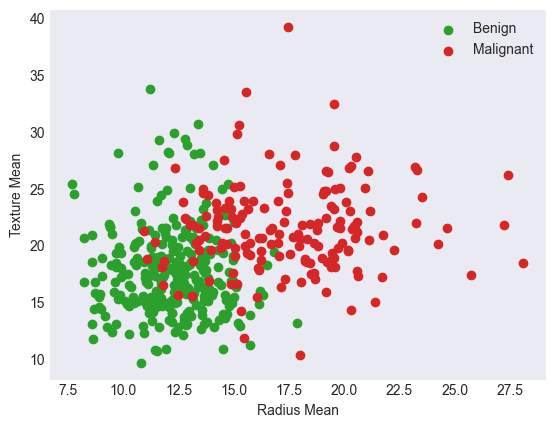

In [ ]:
# Visualize data distribution
benign_points = x_train[y_train == 0].to_numpy()
malignant_points = x_train[y_train == 1].to_numpy()

plt.scatter(benign_points[:, 0], benign_points[:, 1], color='tab:green', label='Benign')
plt.scatter(malignant_points[:, 0], malignant_points[:, 1], color='tab:red', label='Malignant')
plt.xlabel('Radius Mean')
plt.ylabel('Texture Mean')
plt.legend()
plt.show()

# Sigmoid Function - Mathematical Foundation

## Overview
The sigmoid function is the core activation function in logistic regression. It maps any real number to a value between 0 and 1, making it perfect for binary classification problems where we need to output probabilities.

## Mathematical Formula
**σ(z) = 1 / (1 + e^(-z))**

Where:
- z = linear combination of features (z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b)
- e = Euler's number (≈ 2.718)

## Key Properties
- **Output range**: (0, 1) - perfect for probabilities
- **S-shaped curve**: Smooth transition from 0 to 1
- **Differentiable**: Allows gradient-based optimization
- **Interpretable**: Output can be interpreted as probability of positive class

![alt text](../sigmoid_func.png)

In [ ]:
# Sigmoid activation function: maps any real number to (0,1)
def sigmoid(z):
    return 1 / (1 + cp.exp(-z))

# Loss and Cost Functions - Mathematical Foundation

## Loss Function (Cross-Entropy Loss)
The loss function quantifies how wrong our prediction is for a single training example. For logistic regression, we use the cross-entropy loss (also called logistic loss).

**Mathematical Formula:**
**L(y, ŷ) = -[y × log(ŷ) + (1-y) × log(1-ŷ)]**

Where:
- y = actual label (0 or 1)
- ŷ = predicted probability from sigmoid function
- When y=1: Loss = -log(ŷ) → Loss approaches 0 when ŷ→1, ∞ when ŷ→0
- When y=0: Loss = -log(1-ŷ) → Loss approaches 0 when ŷ→0, ∞ when ŷ→1

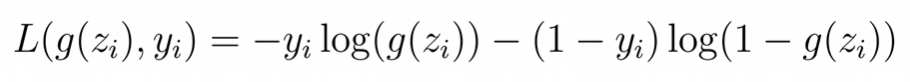

## Cost Function (Average Loss)
The cost function is the average of all individual losses across the entire training dataset. This is what we minimize during training.

**Mathematical Formula:**
**J(w,b) = (1/m) × Σᵢ₌₁ᵐ L(y⁽ⁱ⁾, ŷ⁽ⁱ⁾)**

Where:
- m = number of training examples
- Lower cost indicates better model performance
- Goal: Find w and b that minimize J(w,b)

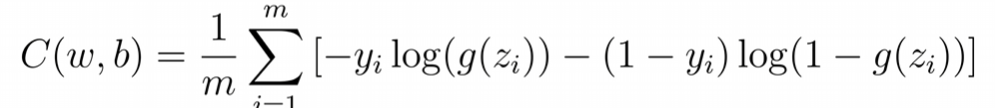

In [ ]:
# Cost function: cross-entropy loss
def cost_function(x, y, w, b):
    z = x @ w + b  # Linear combination
    y_hat = sigmoid(z)
    # Cross-entropy loss
    cost = -(y * cp.log(y_hat) + (1 - y) * cp.log(1 - y_hat))
    return cp.mean(cost)

# Partial Derivatives - Gradient Computation

## Overview
To minimize the cost function using gradient descent, we need to compute partial derivatives of the cost function with respect to each parameter (weights w and bias b). These gradients tell us the direction and magnitude of steepest descent.

## Mathematical Formulas

**Gradient with respect to weights:**
**∂J/∂w = (1/m) × X^T × (ŷ - y)**

**Gradient with respect to bias:**
**∂J/∂b = (1/m) × Σ(ŷ - y)**

Where:
- X^T = transpose of the feature matrix
- ŷ = predicted probabilities from sigmoid function  
- y = actual binary labels
- m = number of training examples
- (ŷ - y) = prediction error for each sample

## Key Insights
- Gradients point in the direction of steepest increase
- We subtract gradients to move toward minimum (steepest decrease)
- Larger errors contribute more to gradient magnitude
- Vectorized computation enables efficient processing of all samples simultaneously

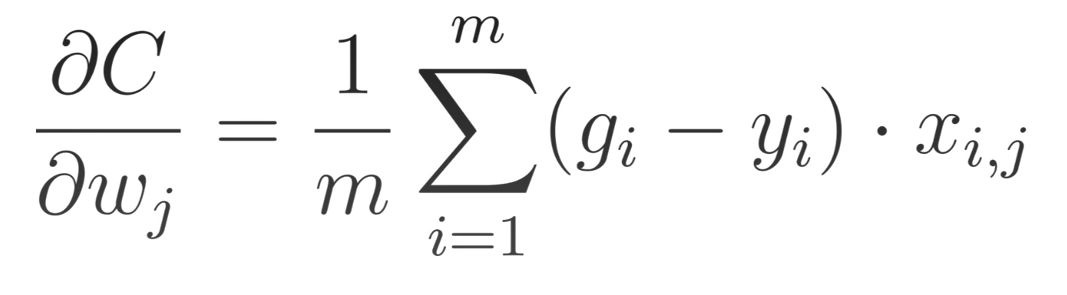

In [ ]:
# Compute gradients for gradient descent
def gradient_function(x, y, w, b):
    m = x.shape[0]
    z = x @ w + b 
    y_hat = sigmoid(z)
    error = y_hat - y
    
    # Calculate gradients
    grad_w = (x.T @ error) / m
    grad_b = cp.mean(error)
    
    return grad_w, grad_b

# Gradient Descent Algorithm - Optimization Engine

## Overview
Gradient descent is an iterative optimization algorithm that finds the minimum of the cost function by repeatedly updating parameters in the direction of steepest descent.

## Algorithm Steps
1. **Initialize** weights (w) and bias (b) to zero or small random values
2. **For each iteration:**
   - Compute predictions using current parameters
   - Calculate cost function value
   - Compute gradients (∂J/∂w and ∂J/∂b)
   - Update parameters using gradients and learning rate
   - Track progress and check for convergence

## Parameter Update Rules
**w := w - α × ∂J/∂w**
**b := b - α × ∂J/∂b**

Where:
- α (alpha) = learning rate (controls step size)
- := means "update/assign"

## Key Hyperparameters
- **Learning Rate (α)**: Too large → overshooting, Too small → slow convergence
- **Iterations**: Maximum number of optimization steps
- **Convergence**: Cost should decrease over iterations (indicates learning)

## Batch vs Mini-batch vs Stochastic
- **Full Batch**: Uses entire training set per iteration (what we implement)
- **Mini-batch**: Uses small subsets of training data
- **Stochastic**: Uses one sample at a time

In [ ]:
# Train model using gradient descent
def gradient_descent(x, y, alpha, iterations):
    n = x.shape[1]
    w = cp.zeros(n)  # Initialize weights
    b = cp.array(0.0)  # Initialize bias

    # Track training progress
    cost_history = []
    iteration_history = []

    for i in range(1, iterations + 1):
        grad_w, grad_b = gradient_function(x, y, w, b)
        w = w - alpha * grad_w  # Update weights
        b = b - alpha * grad_b  # Update bias

        # Log progress every 1000 iterations
        if i % 1000 == 0:
            cost = cost_function(x, y, w, b)
            cost_history.append(cost.item())
            iteration_history.append(i)
            print(f"Iteration {i}/{iterations} ({i/iterations * 100:.2f}%)\t - Cost: {cost.item():.4f}")

    print(f"Training completed!")
    return w, b, cost_history, iteration_history

In [ ]:
# Make predictions using trained model
def predict(x, w, b, threshhold=0.5):
    z = x @ w + b
    y_hat = sigmoid(z)
    return (y_hat >= threshhold).astype(int)  # Convert to binary predictions

In [ ]:
# Set hyperparameters
learning_rate = 0.001
iterations = 20000
threshold = 0.4

# Convert to GPU arrays for faster computation
x_train_cupy = cp.asarray(x_train_scaled)
y_train_cupy = cp.asarray(y_train)

# Train the model
w, b, cost_history, iteration_history = gradient_descent(x_train_cupy, y_train_cupy, learning_rate, iterations)

Iteration 1000/20000 (5.00%)	 - Cost: 0.2549
Iteration 2000/20000 (10.00%)	 - Cost: 0.1920
Iteration 3000/20000 (15.00%)	 - Cost: 0.1635
Iteration 4000/20000 (20.00%)	 - Cost: 0.1466
Iteration 5000/20000 (25.00%)	 - Cost: 0.1351
Iteration 6000/20000 (30.00%)	 - Cost: 0.1267
Iteration 7000/20000 (35.00%)	 - Cost: 0.1202
Iteration 8000/20000 (40.00%)	 - Cost: 0.1150
Iteration 9000/20000 (45.00%)	 - Cost: 0.1107
Iteration 10000/20000 (50.00%)	 - Cost: 0.1071
Iteration 11000/20000 (55.00%)	 - Cost: 0.1040
Iteration 12000/20000 (60.00%)	 - Cost: 0.1013
Iteration 13000/20000 (65.00%)	 - Cost: 0.0989
Iteration 14000/20000 (70.00%)	 - Cost: 0.0968
Iteration 15000/20000 (75.00%)	 - Cost: 0.0949
Iteration 16000/20000 (80.00%)	 - Cost: 0.0932
Iteration 17000/20000 (85.00%)	 - Cost: 0.0916
Iteration 18000/20000 (90.00%)	 - Cost: 0.0902
Iteration 19000/20000 (95.00%)	 - Cost: 0.0889
Iteration 20000/20000 (100.00%)	 - Cost: 0.0877
Training completed!


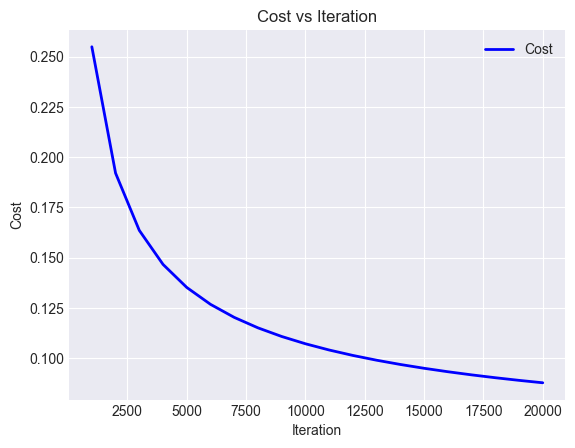

In [ ]:
# Plot training progress
plt.plot(iteration_history, cost_history, label='Cost', color='blue', linewidth=2)
plt.title('Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on test set
test_predictions = predict(cp.asarray(x_test_scaled), cp.asarray(w), cp.array(b), threshold)
test_predictions = test_predictions.get()  # Convert back from GPU

# Calculate metrics
accuracy = accuracy_score(y_test, test_predictions)
confusionMatrix = confusion_matrix(y_test, test_predictions)
report = classification_report(y_test, test_predictions)

print(f"Accuracy score: {accuracy:.4f}")
print(confusionMatrix)
print(f"Classification Report: ")
print(report)

Accuracy score: 0.9649
[[68  3]
 [ 1 42]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



# Scikit-learn Library - Benchmark Comparison

## Purpose of Comparison
We'll now compare our custom implementation with scikit-learn's optimized logistic regression to:

1. **Validate our implementation** - Ensure our math and code are correct
2. **Benchmark performance** - Compare accuracy and efficiency  
3. **Understand optimization differences** - Learn from professional implementations

## Key Differences

### Our Implementation:
- **Algorithm**: Basic gradient descent with fixed learning rate
- **Optimization**: Simple parameter updates (w := w - α∇w)
- **Regularization**: None implemented
- **Convergence**: Fixed number of iterations
- **Hardware**: GPU acceleration with CuPy

### Scikit-learn Implementation:
- **Algorithm**: Advanced solvers (L-BFGS, liblinear, SAG, SAGA)
- **Optimization**: Sophisticated convergence criteria and adaptive learning
- **Regularization**: L1/L2 regularization included by default (C parameter)
- **Convergence**: Automatic stopping based on tolerance
- **Hardware**: Optimized CPU implementation

## Expected Outcome
Both implementations should achieve similar accuracy if our mathematics is correct, demonstrating that understanding the fundamentals allows us to build effective models from scratch.

In [ ]:
# Compare with scikit-learn implementation
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train_scaled, y_train)

LogisticRegression()

In [ ]:
# Evaluate scikit-learn model
predictions = model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
confusionMatrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(confusionMatrix)
print(f"Classification report: ")
print(report)

Accuracy: 0.9737
[[70  1]
 [ 2 41]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

